In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline
from copy import deepcopy

import os
import sys
from pathlib import Path
import pandas as pd

from fastai.vision import *
from fastai.callbacks import *
from fastai.layers import AdaptiveConcatPool2d
import torch
from efficientnet_pytorch import EfficientNet
import wandb
from wandb.fastai import WandbCallback
import timm
import pretrainedmodels
from kornia.losses import FocalLoss
from fastai2.layers import MishJit
from sklearn.utils.class_weight import compute_class_weight

from sklearn.metrics import recall_score


def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

## Params

In [2]:
NAME = ''
WANDB_MODE = 'dryrun'

DATA_PATH = Path('/home/lextoumbourou/bengaliai-cv19/data')
IMAGE_DATA_PATH = Path(DATA_PATH/'grapheme-imgs-128x128')
OUTPUT_PATH = Path(DATA_PATH/'working')
LABELS_PATH = Path(DATA_PATH/'iterative-stratification')

VALID_PCT = 0.2
SEED = 421
BATCH_SIZE = 128
IMG_SIZE = 128

MAX_WARP = 0.2
P_AFFINE = 0.75
MAX_ROTATE = 40.
MAX_ZOOM = 1.1
P_LIGHTING = 0.75
MAX_LIGHTING = 0.2
MAX_COUNT_RANDOM_ERASING = 3
LABEL_SMOOTHING_EPS = 0.1

MAX_EPOCHS = 150

ENCODER_ARCH = 'efficientnet-b0'

GRAPHEME_ROOT_WEIGHT = 0.7
VOWEL_DIACRITIC_WEIGHT = 0.1
CONSONANT_DIACRITIC_WEIGHT = 0.2
MODEL_HEAD = 'mish_head'

SAMPLE_SIZE = None

PROG_SPRINKES = False
USE_FP16 = False

NORM_MEAN = 0.0692
NORM_STD = 0.2051

USE_CUTMIX = True

REDUCE_LR_PATIENCE = 6
REDUCE_LR_FACTOR = 0.2

LR = 3e-3

LOAD_EXPERIMENT = None

EARLY_STOP_PATIENCE = 20

In [3]:
# Parameters
ENCODER_ARCH = "se_resnext50_32x4d"
IMG_SIZE = 64
BATCH_SIZE = 896
USE_FP16 = True
USE_CUTMIX = True
USE_MIXUP = True
REDUCE_LR_PATIENCE = 5
REDUCE_LR_FACTOR = 0.5
WANDB_MODE = "run"
NAME = "se_resnext50_lower_reduce_factor"
OUTPUT_VAL_SIZE = None


In [4]:
if isinstance(LR, list): LR = slice(*LR)

In [5]:
seed_everything(seed=SEED)

In [6]:
!wandb login 563765550fd7b64fd10129216209724e03f3f20c

wandb: Appending key for api.wandb.ai to your netrc file: /home/lextoumbourou/.netrc
Successfully logged in to Weights & Biases!


In [7]:
# Turn this off before running!!
os.environ['WANDB_MODE'] = WANDB_MODE

In [8]:
wandb.init(project="bengaliai-cv19", name=NAME)

wandb.config.img_size = IMG_SIZE
wandb.config.batch_size = BATCH_SIZE
wandb.config.seed = SEED

wandb.config.max_warp = MAX_WARP
wandb.config.p_affine = P_AFFINE
wandb.config.max_rotate = MAX_ROTATE
wandb.config.max_zoom = MAX_ZOOM
wandb.config.p_lighting = P_LIGHTING
wandb.config.max_lighting = MAX_LIGHTING
wandb.config.max_count_random_erasing = MAX_COUNT_RANDOM_ERASING
wandb.config.grapheme_root_weight = GRAPHEME_ROOT_WEIGHT
wandb.config.vowel_diacritic_weight = VOWEL_DIACRITIC_WEIGHT
wandb.config.consonant_diacritic_weight = CONSONANT_DIACRITIC_WEIGHT
wandb.config.sample_size = SAMPLE_SIZE
wandb.config.encoder_arch = ENCODER_ARCH
wandb.config.max_epochs = MAX_EPOCHS
wandb.config.prog_sprinkles = PROG_SPRINKES
wandb.config.label_smoothing_eps = LABEL_SMOOTHING_EPS
wandb.config.encoder_arch = ENCODER_ARCH
wandb.config.norm_mean = NORM_MEAN
wandb.config.norm_std = NORM_STD
wandb.config.use_fp16 = USE_FP16
wandb.config.use_cutmix = USE_CUTMIX
wandb.config.reduce_lr_patience = REDUCE_LR_PATIENCE
wandb.config.lr = str(LR)
wandb.config.reduce_lr_factor = REDUCE_LR_FACTOR
wandb.config.load_experiment = LOAD_EXPERIMENT
wandb.config.early_stop_patience = EARLY_STOP_PATIENCE

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


wandb: Wandb version 0.8.27 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


## Create datasets and dataloaders

In [9]:
train_df = pd.read_csv(LABELS_PATH/'train_with_fold.csv')
if wandb.config.sample_size:
    print("About to reduce train size.")
    train_df = train_df.sample(n=wandb.config.sample_size, random_state=SEED).reset_index(drop=True)

In [10]:
train_df.head()

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme,id,fold
0,Train_0,15,9,5,ক্ট্রো,0,3
1,Train_1,159,0,0,হ,1,2
2,Train_2,22,3,5,খ্রী,2,4
3,Train_3,53,2,2,র্টি,3,2
4,Train_4,71,9,5,থ্রো,4,1


In [11]:
train_df.grapheme_root.value_counts().plot.bar(figsize=(20, 4), title="Grapheme root", rot=90)

In [12]:
train_df.vowel_diacritic.value_counts().plot.bar(title="Vowel diacrititc")

In [13]:
train_df.consonant_diacritic.value_counts().plot.bar(title="Consonant diacrititc")

In [14]:
train_tfms = [
    symmetric_warp(
        magnitude=(-wandb.config.max_warp, wandb.config.max_warp),
        p=wandb.config.p_affine
    ),
    rotate(
        degrees=(-wandb.config.max_rotate, wandb.config.max_rotate),
        p=wandb.config.p_affine
    ),
    rand_zoom(
        scale=(1., wandb.config.max_zoom), p=wandb.config.p_affine
    ),
    brightness(
        change=(0.5*(1 - wandb.config.max_lighting), 0.5*(1 + wandb.config.max_lighting)),
        p=wandb.config.p_lighting
    ),
    contrast(
        scale=(1-wandb.config.max_lighting, 1/(1-wandb.config.max_lighting)),
        p=wandb.config.p_lighting
    ),
    cutout(n_holes=(1, 6), length=(5, 15), p=.5)
]

In [15]:
train_df['is_valid'] = train_df.fold == 0

In [16]:
grapheme_root_class_weight = compute_class_weight('balanced', range(train_df.grapheme_root.max() + 1), y=train_df.grapheme_root)
vowel_diacritic_class_weight = compute_class_weight('balanced', range(train_df.vowel_diacritic.max() + 1), y=train_df.vowel_diacritic)
consonant_diacritic_class_weight = compute_class_weight('balanced', range(train_df.consonant_diacritic.max() + 1), y=train_df.consonant_diacritic)

In [17]:
stats = ([wandb.config.norm_mean], [wandb.config.norm_std])

data = (
    ImageList.from_df(
        path=DATA_PATH, df=train_df, folder='./grapheme-imgs-128x128/', suffix='.png',
        cols='image_id', convert_mode='L'
    )
    .split_from_df(col='is_valid')
    .label_from_df(cols=['grapheme_root', 'vowel_diacritic', 'consonant_diacritic'])
    .transform((train_tfms, []), size=wandb.config.img_size, padding_mode='zeros')
    .databunch(bs=wandb.config.batch_size)
).normalize(stats)

In [18]:
data.show_batch()

In [19]:
class MixUpLoss(Module):
    "Adapt the loss function `crit` to go with mixup."
    
    def __init__(self, crit, reduction='mean'):
        super().__init__()
        if hasattr(crit, 'reduction'): 
            self.crit = crit
            self.old_red = crit.reduction
            setattr(self.crit, 'reduction', 'none')
        else: 
            self.crit = partial(crit, reduction='none')
            self.old_crit = crit
        self.reduction = reduction
        
    def forward(self, output, target):
        if len(target.shape) == 2 and target.shape[1] == 7:
            loss1, loss2 = self.crit(output,target[:,0:3].long()), self.crit(output,target[:,3:6].long())
            d = loss1 * target[:,-1] + loss2 * (1-target[:,-1])
        else:  d = self.crit(output, target)
        if self.reduction == 'mean':    return d.mean()
        elif self.reduction == 'sum':   return d.sum()
        return d
    
    def get_old(self):
        if hasattr(self, 'old_crit'):  return self.old_crit
        elif hasattr(self, 'old_red'): 
            setattr(self.crit, 'reduction', self.old_red)
            return self.crit
        
def rand_bbox(last_input_size, λ):
    '''lambd is always between .5 and 1'''

    W = last_input_size[-1]
    H = last_input_size[-2]
    cut_rat = np.sqrt(1. - λ) # 0. - .707
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    if len(last_input_size) == 4:
        bby2 = np.clip(cy + cut_h // 2, 0, H)
    else: bby2 = last_input_size[1]

    return bbx1, bby1, bbx2, bby2


class CutMixCallback(LearnerCallback):
    '''Adapted from :
    paper: https://arxiv.org/abs/1905.04899
    github: https://github.com/clovaai/CutMix-PyTorch
    and mixup in the fastai library.'''

    def __init__(self, learn:Learner, alpha:float=1., stack_y:bool=True):
        super().__init__(learn)
        self.alpha,self.stack_y = alpha,stack_y

    def on_train_begin(self, **kwargs):
        if self.stack_y:
            self.learn.loss_func = MixUpLoss(self.learn.loss_func)

    def on_batch_begin(self, last_input, last_target, train, **kwargs):
        "Applies cutmix to `last_input` and `last_target` if `train`."
        if not train or self.alpha == 0:
            return
        λ = np.random.beta(self.alpha, self.alpha)
        λ = max(λ, 1- λ)
        bs = last_target.size(0)
        idx = torch.randperm(bs).to(last_input.device)
        x1, y1 = last_input[idx], last_target[idx]

        #Get new input
        last_input_size = last_input.size()
        bbx1, bby1, bbx2, bby2 = rand_bbox(last_input_size, λ)
        new_input = last_input.clone()
        new_input[..., bby1:bby2, bbx1:bbx2] = x1[..., bby1:bby2, bbx1:bbx2]
        #λ = last_input.new([λ])
        λ = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (last_input_size[-1] * last_input_size[-2]))
        λ = last_input.new([λ])

        # modify last target
        if self.stack_y:
            new_target = torch.cat([last_target.float(), y1.float(),
                                    λ.repeat(last_input_size[0]).unsqueeze(1).float()], 1)
        else:
            if len(last_target.shape) == 2:
                λ = λ.unsqueeze(1).float()
            new_target = last_target.float() * λ + y1.float() * (1-λ)

        return {'last_input': new_input, 'last_target': new_target}

    def on_train_end(self, **kwargs):
        if self.stack_y: self.learn.loss_func = self.learn.loss_func.get_old()


class MixUpCallback(LearnerCallback):
    "Callback that creates the mixed-up input and target."
    def __init__(self, learn:Learner, alpha:float=0.4, stack_x:bool=False, stack_y:bool=True):
        super().__init__(learn)
        self.alpha,self.stack_x,self.stack_y = alpha,stack_x,stack_y
    
    def on_train_begin(self, **kwargs):
        if self.stack_y: self.learn.loss_func = MixUpLoss(self.learn.loss_func)
        
    def on_batch_begin(self, last_input, last_target, train, **kwargs):
        "Applies mixup to `last_input` and `last_target` if `train`."
        if not train: return
        lambd = np.random.beta(self.alpha, self.alpha, last_target.size(0))
        lambd = np.concatenate([lambd[:,None], 1-lambd[:,None]], 1).max(1)
        lambd = last_input.new(lambd)
        shuffle = torch.randperm(last_target.size(0)).to(last_input.device)
        x1, y1 = last_input[shuffle], last_target[shuffle]
        if self.stack_x:
            new_input = [last_input, last_input[shuffle], lambd]
        else: 
            out_shape = [lambd.size(0)] + [1 for _ in range(len(x1.shape) - 1)]
            new_input = (last_input * lambd.view(out_shape) + x1 * (1-lambd).view(out_shape))
        if self.stack_y:
            new_target = torch.cat([last_target.float(), y1.float(), lambd[:,None].float()], 1)
        else:
            if len(last_target.shape) == 2:
                lambd = lambd.unsqueeze(1).float()
            new_target = last_target.float() * lambd + y1.float() * (1-lambd)
        return {'last_input': new_input, 'last_target': new_target}  
    
    def on_train_end(self, **kwargs):
        if self.stack_y: self.learn.loss_func = self.learn.loss_func.get_old()
            

class MixUpOrCutMix(LearnerCallback):
    def __init__(self, learn, mix_up_kwargs=None, cut_mix_kwargs=None):
        super().__init__(learn)
        self.mix_up_kwargs = mix_up_kwargs or {}
        self.cut_mix_kwargs = cut_mix_kwargs or {}
        self.mixup = MixUpCallback(learner, **self.mix_up_kwargs)
        self.cutmix = CutMixCallback(learner, **self.cut_mix_kwargs)
        
    def on_train_begin(self, **kwargs):
        self.mixup.on_train_begin(**kwargs)
        self.cutmix.on_train_begin(**kwargs)
        
    def on_batch_begin(self, last_input, last_target, train, **kwargs):
        if not train:
            return
        
        if np.random.rand() < 0.5:
            return self.mixup.on_batch_begin(last_input, last_target, train, **kwargs)
        else:
            return self.cutmix.on_batch_begin(last_input, last_target, train, **kwargs)
        
    def on_train_end(self, **kwargs):
        self.mixup.on_train_end(**kwargs)
        self.cutmix.on_train_end(**kwargs)

## Loss and metrics

In [20]:
class MetricBase(Callback):
    def __init__(self, average='macro'):
        super().__init__()
        self.n_classes = 0
        self.average = average
        self.cm = None
        self.eps = 1e-9
        
    def on_epoch_begin(self, **kwargs):
        self.tp = 0
        self.fp = 0
        self.cm = None
    
    def on_batch_end(self, last_output:Tensor, last_target:Tensor, **kwargs):
        last_output = last_output[self.idx]
        last_target = last_target[:,self.idx]
        preds = last_output.argmax(-1).view(-1).cpu()
        targs = last_target.long().cpu()
        
        if self.n_classes == 0:
            self.n_classes = last_output.shape[-1]
            self.x = torch.arange(0, self.n_classes)
        cm = ((preds==self.x[:, None]) & (targs==self.x[:, None, None])) \
          .sum(dim=2, dtype=torch.float32)
        if self.cm is None: self.cm =  cm
        else:               self.cm += cm

    def _weights(self, avg:str):
        if self.n_classes != 2 and avg == "binary":
            avg = self.average = "macro"
            warn("average=`binary` was selected for a non binary case. \
                 Value for average has now been set to `macro` instead.")
        if avg == "binary":
            if self.pos_label not in (0, 1):
                self.pos_label = 1
                warn("Invalid value for pos_label. It has now been set to 1.")
            if self.pos_label == 1: return Tensor([0,1])
            else: return Tensor([1,0])
        elif avg == "micro": return self.cm.sum(dim=0) / self.cm.sum()
        elif avg == "macro": return torch.ones((self.n_classes,)) / self.n_classes
        elif avg == "weighted": return self.cm.sum(dim=1) / self.cm.sum()
        
    def _recall(self):
        rec = torch.diag(self.cm) / (self.cm.sum(dim=1) + self.eps)
        if self.average is None: return rec
        else:
            if self.average == "micro": weights = self._weights(avg="weighted")
            else: weights = self._weights(avg=self.average)
            return (rec * weights).sum()
    
    def on_epoch_end(self, last_metrics, **kwargs):
        return add_metrics(last_metrics, self._recall())

    
class GraphemeRoot(MetricBase):
    idx = 0

    
class VowelDiacritic(MetricBase):
    idx = 1


class ConsonantDiacritic(MetricBase):
    idx = 2


class RecallCombine(Callback):
    def __init__(self):
        super().__init__()
        self.grapheme = GraphemeRoot()
        self.vowel = VowelDiacritic()
        self.consonant = ConsonantDiacritic()
        
    def on_epoch_begin(self, **kwargs):
        self.grapheme.on_epoch_begin(**kwargs)
        self.vowel.on_epoch_begin(**kwargs)
        self.consonant.on_epoch_begin(**kwargs)
    
    def on_batch_end(self, last_output:Tensor, last_target:Tensor, **kwargs):
        self.grapheme.on_batch_end(last_output, last_target, **kwargs)
        self.vowel.on_batch_end(last_output, last_target, **kwargs)
        self.consonant.on_batch_end(last_output, last_target, **kwargs)
        
    def on_epoch_end(self, last_metrics, **kwargs):
        return add_metrics(
            last_metrics,
            0.5 * self.grapheme._recall() +
            0.25 * self.vowel._recall() +
            0.25 * self.consonant._recall()
        )

## Model

In [21]:
from torch.nn.parameter import Parameter


def gem(x, p=3, eps=1e-6):
    if wandb.config.use_fp16:
        x = x.double() # x=x.to(torch.float32) # comment this during inference

    x = F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)
    
    if wandb.config.use_fp16:
        x = x.half()

    return x # Comment this line in inference code use ## return x


class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM,self).__init__()
        self.p = Parameter(torch.ones(1)*p)
        self.eps = eps

    def forward(self, x):
        return gem(x, p=self.p, eps=self.eps)

    def __repr__(self):
        return self.__class__.__name__ + '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + ', ' + 'eps=' + str(self.eps) + ')'

In [22]:
class AdaptiveConcatWithGemPool2d(Module):
    "Layer that concats `AdaptiveAvgPool2d` and `AdaptiveMaxPool2d`."
    def __init__(self, sz:Optional[int]=None):
        "Output will be 2*sz or 2 if sz is None"
        self.output_size = sz or 1
        self.ap = GeM()
        self.mp = nn.AdaptiveMaxPool2d(self.output_size)

    def forward(self, x):
        return torch.cat([self.mp(x), self.ap(x)], 1)

In [23]:
class MishHead(nn.Module):
    def __init__(self, input_size: int, output_size: int, dropout_ps=0.5):
        super().__init__()

        layers = [
            AdaptiveConcatWithGemPool2d(),
            # AdaptiveConcatPool2d(),
            Flatten(),
            nn.Linear(input_size * 2, 512),
            MishJit(),
            nn.BatchNorm1d(512),
            nn.Dropout(dropout_ps),
            nn.Linear(512, output_size)
        ]

        self.fc = nn.Sequential(*layers)
        self._init_weight()

    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1.0)
                m.bias.data.zero_()

    def forward(self, x):
        return self.fc(x)

In [24]:
class BengaliModel(nn.Module):
    def __init__(self, encoder, encoder_output_features):
        super().__init__()
        
        self.encoder = encoder
        
        self.fc_grapheme_root = MishHead(encoder_output_features, output_size=168)
        self.fc_vowel_diacritic = MishHead(encoder_output_features, output_size=11)
        self.fc_consonant_diacritic = MishHead(encoder_output_features, output_size=7)
        
    def forward(self, inputs):
        # Convolution layers
        x = self.encoder(inputs)

        return [
            self.fc_grapheme_root(x),
            self.fc_vowel_diacritic(x),
            self.fc_consonant_diacritic(x)
        ]

In [25]:
class LossCombine(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input, target, reduction='mean'):
        x1,x2,x3 = input
        x1,x2,x3 = x1.float(), x2.float(), x3.float()
        y = target.long()

        return (
            wandb.config.grapheme_root_weight * F.cross_entropy(
                x1, y[:,0], reduction=reduction) +
            wandb.config.vowel_diacritic_weight * F.cross_entropy(
                x2,y[:,1], reduction=reduction) +
            wandb.config.consonant_diacritic_weight * F.cross_entropy(
                x3, y[:,2], reduction=reduction)
        )

In [26]:
class EfficientNetModel(nn.Module):
    def __init__(self, model_name):
        super().__init__()
        self.m = EfficientNet.from_pretrained(model_name)
        
    def forward(self, x):
        return self.m.extract_features(x)

In [27]:
class RWightmanModel(nn.Module):
    def __init__(self, model_name):
        super().__init__()
        self.m =  timm.create_model(model_name, pretrained=True)
        
    def forward(self, x):
        return self.m.forward_features(x)

In [28]:
class CadeneModel(nn.Module):
    def __init__(self, model_name):
        super().__init__()

        self.m = pretrainedmodels.__dict__[model_name](num_classes=1000, pretrained='imagenet')
        layer0_weight = deepcopy(self.m.layer0.conv1.weight)
        
        self.m.layer0.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.m.layer0.conv1.weight = nn.Parameter(torch.mean(layer0_weight, dim=1, keepdim=True))
        
    def forward(self, x):
        return self.m.features(x)

## Training

In [29]:
@dataclass
class CutoutScheduler(Callback):
    learn:Learner
    n_holes_max:int=80
    max_at_epoch:int=30
        
    def on_epoch_begin(self, **kwargs):
        i = kwargs['iteration']
        n_epochs = kwargs['n_epochs']
        n_holes_max = int(round(annealing_linear(0, self.n_holes_max, min(i / self.max_at_epoch, 1.))))
        n_holes = (max(n_holes_max-10, 0), n_holes_max)
        print(n_holes)
        self.learn.data.train_ds.tfms[-1].kwargs['n_holes'] = n_holes

In [30]:
if ENCODER_ARCH.startswith('efficientnet-'):
    print(f'Loading EfficientNet models: {ENCODER_ARCH}')
    encoder = EfficientNetModel(ENCODER_ARCH)
    output_feats = encoder.m._fc.in_features
elif ENCODER_ARCH in pretrainedmodels.model_names:
    print(f"Loading Cadene model: {ENCODER_ARCH}")
    encoder = CadeneModel(ENCODER_ARCH)
    output_feats = encoder.m.last_linear.in_features
else:
    print(f"Loading R Wightman model: {ENCODER_ARCH}")
    encoder = RWightmanModel(ENCODER_ARCH)
    output_feats = encoder.m.classifier.in_features

Loading Cadene model: se_resnext50_32x4d


In [31]:
model = BengaliModel(encoder=encoder, encoder_output_features=output_feats)

learner = Learner(
    data, model, loss_func=LossCombine(),
    metrics=[GraphemeRoot(), VowelDiacritic(), ConsonantDiacritic(), RecallCombine()],
    callback_fns=WandbCallback
)
learner.clip_grad = 1.0
learner.split([model.fc_grapheme_root])

learner.unfreeze()

if wandb.config.use_fp16:
    print("Convert to fp16")
    learner = learner.to_fp16()

Convert to fp16


In [32]:
if wandb.config.load_experiment:
    print(f'Restoring experiment: {wandb.config.load_experiment}')
    wandb.restore('bestmodel.pth', run_path=wandb.config.load_experiment)
    learner.load(Path(wandb.run.dir)/'bestmodel')

In [33]:
# learner.lr_find()
# learner.recorder.plot()

tensor([64.0000,  7.0000,  4.0000, 81.0000,  2.0000,  0.0000,  0.9844])


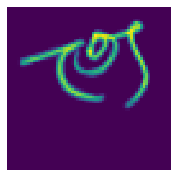

tensor([149.0000,   3.0000,   0.0000,  84.0000,   2.0000,   0.0000,   1.0000])


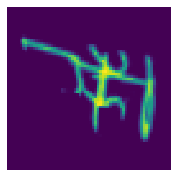

tensor([147.0000,   5.0000,   0.0000, 136.0000,   0.0000,   2.0000,   0.7693])


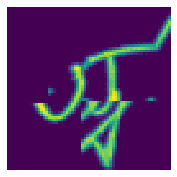

tensor([ 42.0000,   4.0000,   1.0000, 108.0000,   2.0000,   0.0000,   0.9831])


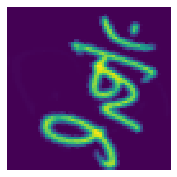

tensor([ 81.0000,   3.0000,   0.0000, 115.0000,   4.0000,   0.0000,   0.8594])


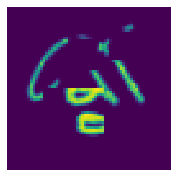

In [34]:
%matplotlib inline

def show_mixup_or_cutmix(learner):
    for i in range(5):
        cb = MixUpOrCutMix(learner)
        xb, yb = learner.data.one_batch()
        tfms = learner.data.train_ds.tfms
        for i in range(len(xb)):
            xb[i] = Image(xb[i]).apply_tfms(tfms).data
        
        batch_output = cb.on_batch_begin(xb, yb, True)
        
        print(batch_output['last_target'][0])
        
        Image(batch_output['last_input'][0]).show()
        
        plt.show()
        
show_mixup_or_cutmix(learner)

In [35]:
callbacks=[
    CSVLogger(learner, OUTPUT_PATH/'history.csv'),
    SaveModelCallback(
        learner, monitor='recall_combine', mode='max', name=NAME
    ),
    # MixUpCallback(learner),
    # CutMixCallback(learner),
    MixUpOrCutMix(learner),
    ReduceLROnPlateauCallback(
        learner, patience=wandb.config.reduce_lr_patience,
        monitor='valid_loss', mode='min', min_lr=1e-6, factor=wandb.config.reduce_lr_factor
    ),
    EarlyStoppingCallback(learner, monitor='valid_loss', mode='min', patience=wandb.config.early_stop_patience)
]

if wandb.config.prog_sprinkles:
    callbacks.append(CutoutScheduler(learner, n_holes_max=80))
    
learner.fit(
    wandb.config.max_epochs,
    LR,
    callbacks=callbacks
)

epoch,train_loss,valid_loss,grapheme_root,vowel_diacritic,consonant_diacritic,recall_combine,time
0,2.437694,1.346221,0.481101,0.750496,0.658787,0.592871,05:48
1,1.999373,0.847397,0.704322,0.868003,0.744031,0.755170,04:56
2,1.751604,0.622122,0.753396,0.879564,0.845396,0.807938,04:57
3,1.605137,0.443837,0.842318,0.941787,0.911875,0.884574,04:57
4,1.701308,0.540698,0.829947,0.925785,0.901611,0.871823,04:57
5,1.651296,0.532538,0.808154,0.929108,0.886119,0.857884,04:57
6,1.718460,0.466252,0.843155,0.934330,0.894202,0.878710,04:57
7,1.558079,0.482156,0.870252,0.946301,0.928716,0.903880,05:00
8,1.633234,0.467625,0.863987,0.931242,0.932430,0.897912,05:00
9,1.554277,0.462316,0.857491,0.949483,0.922066,0.896632,04:59


Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


wandb: Wandb version 0.8.27 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Better model found at epoch 0 with valid_loss value: 1.3462210893630981.


Better model found at epoch 0 with recall_combine value: 0.5928710699081421.


Better model found at epoch 1 with valid_loss value: 0.8473972678184509.


Better model found at epoch 1 with recall_combine value: 0.7551697492599487.


Better model found at epoch 2 with valid_loss value: 0.6221215724945068.


Better model found at epoch 2 with recall_combine value: 0.8079379796981812.


Better model found at epoch 3 with valid_loss value: 0.4438371956348419.


Better model found at epoch 3 with recall_combine value: 0.8845744132995605.


Better model found at epoch 7 with recall_combine value: 0.9038804173469543.


Epoch 9: reducing lr to 0.0015


Better model found at epoch 10 with valid_loss value: 0.3638308644294739.


Better model found at epoch 10 with recall_combine value: 0.9265588521957397.


Better model found at epoch 13 with valid_loss value: 0.29916733503341675.


Better model found at epoch 13 with recall_combine value: 0.9357140064239502.


Better model found at epoch 15 with valid_loss value: 0.25038594007492065.


Better model found at epoch 15 with recall_combine value: 0.9384966492652893.


Better model found at epoch 20 with valid_loss value: 0.22857652604579926.


Better model found at epoch 20 with recall_combine value: 0.9392108917236328.


Better model found at epoch 22 with recall_combine value: 0.9412130117416382.


Better model found at epoch 25 with recall_combine value: 0.9434494376182556.


Epoch 26: reducing lr to 0.00075


Better model found at epoch 27 with valid_loss value: 0.21091997623443604.


Better model found at epoch 27 with recall_combine value: 0.9484336376190186.


Better model found at epoch 29 with recall_combine value: 0.9485077857971191.


Better model found at epoch 31 with valid_loss value: 0.2095761001110077.


Better model found at epoch 31 with recall_combine value: 0.9488362669944763.


Better model found at epoch 35 with recall_combine value: 0.95311039686203.


Epoch 37: reducing lr to 0.000375


Better model found at epoch 39 with valid_loss value: 0.20603908598423004.


Better model found at epoch 39 with recall_combine value: 0.9559608697891235.


Better model found at epoch 40 with valid_loss value: 0.19272592663764954.


Better model found at epoch 45 with recall_combine value: 0.9563848376274109.


Better model found at epoch 46 with valid_loss value: 0.17963653802871704.


Better model found at epoch 46 with recall_combine value: 0.9565048217773438.


Epoch 52: reducing lr to 0.0001875


Better model found at epoch 54 with recall_combine value: 0.957190990447998.


Epoch 58: reducing lr to 9.375e-05


Epoch 64: reducing lr to 4.6875e-05


Epoch 67: early stopping


Loaded best saved model from /home/lextoumbourou/bengaliai-cv19/wandb/run-20200219_064418-vl79qlbs/bestmodel.pth


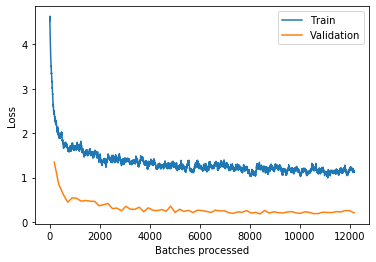

In [36]:
learner.recorder.plot_losses()

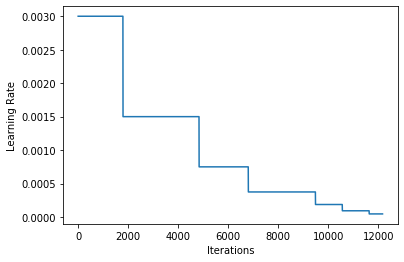

In [37]:
learner.recorder.plot_lr()